In [1]:
include("load_save.jl")
R, X, Y, L, F, Y, PY = load_big_dataset("avGFP", val_mode=true);
R1, X1, Y1, L1, MF1, SF1, Y1, PY1 = load_small_dataset("avGFPs", 'B', val_mode=true);
R2, X2, Y2, L2, MF2, SF2, Y2, PY2 = load_small_dataset("avGFPs", 'C', val_mode=true);
R3, X3, Y3, L3, MF3, SF3, Y3, PY3 = load_small_dataset("avGFPs", 'F', val_mode=true);

Dataset : avGFP_B


Dataset : avGFPs_B


Dataset : avGFPs_C


Dataset : avGFPs_F


In [2]:
using XLSX, FASTX, DataFrames, AverageShiftedHistograms, Loess, PyPlot, Printf

In [3]:
M = load_dataset_model("avGFP"); # brightness
M1 = load_dataset_model("avGFPs", 'B'); # emission
M2 = load_dataset_model("avGFPs", 'C'); # exciation
M3 = load_dataset_model("avGFPs", 'F'); # brightness

In [4]:
excel_data = DataFrame(XLSX.readtable("SIData/avGFP.xlsx", "Sheet1", infer_eltypes=true))
ref_seq = [FASTA.sequence(String, record) for record in open(FASTA.Reader, "SIData/avGFP_ref.fasta")][1]
ref_seq = collect(ref_seq);

In [5]:
seq_vector  = Vector{String}()
for mut in excel_data[!, 2]
    seq = deepcopy(ref_seq)
    seq[[65, 72, 77, 203]] .= collect(mut)
    push!(seq_vector, join(seq))
end

In [39]:
data_vector = [[M, L, "avGFP_b"], [M1, L1, "avGFPs_b"], [M2, L2, "avGFPs_c"], [M3, L3, "avGFPs_f"]];
for i in eachindex(data_vector)
    push!(data_vector[i], parallel_predict(data_vector[i][1], data_vector[i][2], seq_vector))
end

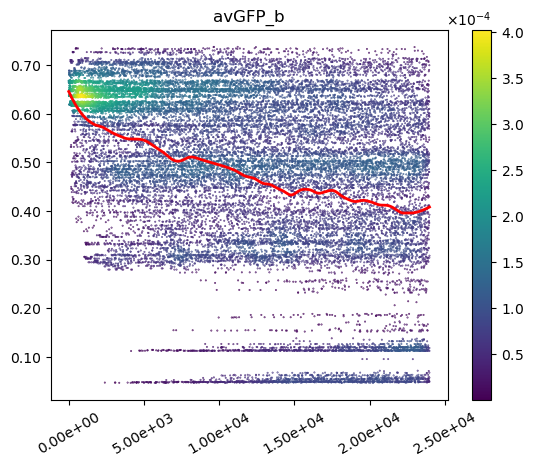

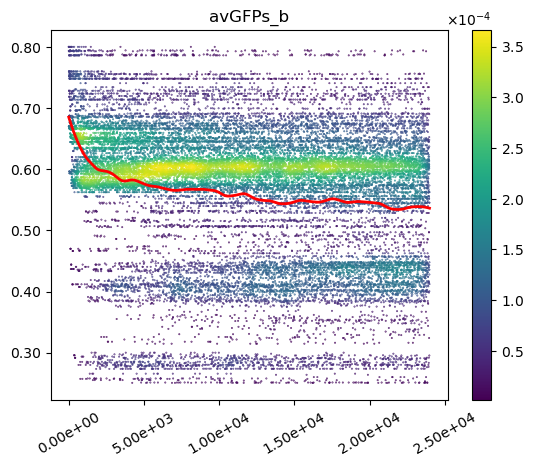

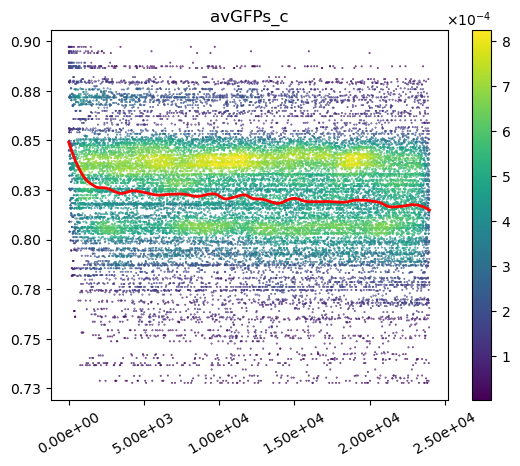

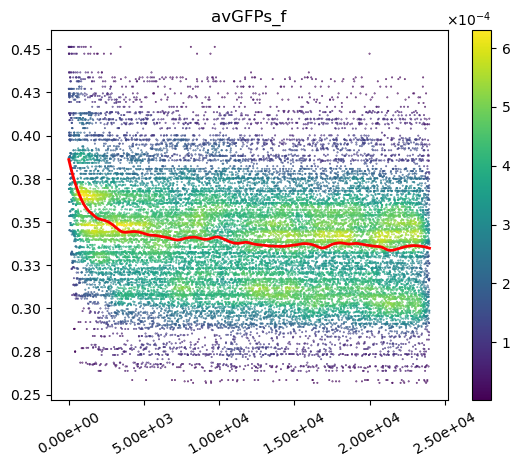

In [40]:
ratio = 0.15
for data in data_vector
    m, l, ti, ans = data
    # ans = min_max_norm(ans)
    
    ans = ans[1:floor(Int, ratio*length(ans))]
    xs = 1:length(ans)
    ys = ans

    model = loess(xs, ys; span=0.15)
    us = range(extrema(xs)...; step=0.1)
    vs = Loess.predict(model, us)

    color = Vector{Float64}()
    ke = AverageShiftedHistograms.Kernels.gaussian
    kde = ash(xs, ys, nbin=150, kernelx=ke, kernely=ke)
    for (tru, val) in zip(xs, ys) 
        push!(color, AverageShiftedHistograms.pdf(kde, tru, val))
    end
    sorted_idx = sortperm(color)

    fig, ax = subplots()
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2e"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
    xticks(rotation=30)
    scatter(xs[sorted_idx], ys[sorted_idx], c=color[sorted_idx], s=0.15)
    plot(us, vs, linewidth=2, c="red")
    cbar = colorbar()
    cbar.ax.ticklabel_format(useMathText=true, scilimits=(0, 0))
    title(ti)

    display(gcf())
    close("all")
end

In [ ]:
bright_ind = [2, 1, 3, 6, 5, 28, 8, 25, 34, 32, 30, 55]
ex_wavelength = [28, 25, 5, 3, 1, 2, 4];

In [ ]:
data_vector = [(M, L, bright_ind, "avGFP_B"), (M1, L1, ex_wavelength, "avGFPs_C"), (M2, L2, bright_ind, "avGFPs_F")];

In [ ]:
for data in data_vector
    m, l, ind, ti = data
    y = min_max_norm(parallel_predict(m, l, seq_vector))[1:78]
    dot_size = 10
    fig, ax = subplots(figsize=(8, 3))
    ax.scatter(1:78, y, s=dot_size)
    ax.scatter(ind, y[ind], color="orange", s=dot_size)
    title(ti)

    for (ind, (_x, _y)) in enumerate(zip(ind, y[ind]))
        ax.annotate(string(ind), (_x, _y))
    end

    display(gcf())
    close("all")
end

In [ ]:
data_vector = [(M, L, F, "avGFP_B"), (M1, L1, MF1, "avGFPs_C"), (M2, L2, MF2, "avGFPs_F")];

In [ ]:
for ((m1, l1, f1, n1), (m2, l2, f2, n2)) in combinations(data_vector, 2)
    l1data = sort(collect(zip(f1, l1)), by = x -> -x[1])
    l2data = sort(collect(zip(f2, l2)), by = x -> -x[1])

    x = Vector{Float64}()
    y = Vector{Float64}()
    for (F, L) in l1data
        l2rank = findfirst(x -> x[2] == L, l2data)
        if !isnothing(l2rank)
            push!(x, F)
            push!(y, l2data[l2rank][1])
        end
    end
    x ./= maximum(x)
    y ./= maximum(y)
    
    figure(figsize=(4.8, 4.8))
    scatter(x, y, s=8)
    xl = xlim(); yl = ylim()
    plot([-2, 2], [-2, 2], color="black")
    xlim(xl...); ylim(yl...)
    annotate((@sprintf "\$R^2\$ : %.4f" r2(x, y)), (0.75, 1))
    xlabel(n1 * " value")
    ylabel(n2 * " value")
    display(gcf())
    close("all")
end